<div><center><img src="https://ml.ucv.ai/logo.png\" width=150"/> </center></div>

# Tarea 3: Transformers y Stacked AutoEncoders

Fuentes:

- [BRISC](https://www.kaggle.com/datasets/briscdataset/brisc2025)


# Descargando datos

Usaremos la librería kagglehub para descargar los datos. Por defecto, los datos son descargados en la `cache` de `.root` necesitamos moverlos a nuestro directorio luego de descargar.

In [1]:
import kagglehub
path = kagglehub.dataset_download('briscdataset/brisc2025')

print('Descarga de datos completa.', path)

Descarga de datos completa. /kaggle/input/brisc2025


In [2]:
!ls {path}

brisc2025


In [3]:
# quitar el anterior y usar copy para evitar descargar varias veces en un ambiente persistente (local)
!rm -r ./briscdataset
!cp -r {path}/brisc2025 ./briscdataset

rm: cannot remove './briscdataset': No such file or directory


Refresquen el directorio de Google Colab

# 🧠 BRISC 2025 Dataset Exploration

BRISC es un conjunto de datos de resonancias magnéticas de alta calidad, anotado por expertos, diseñado para la segmentación y clasificación de tumores cerebrales. Aborda limitaciones comunes en los conjuntos de datos existentes (p. ej., BraTS, Figshare), como el desequilibrio de clases, la focalización tumoral limitada y las inconsistencias en la anotación.

Esta sección provee métodos para entender los datos del dataset **BRISC 2025**. Está modificado para ser usado en `Google Colab` de un tutorial que funcionaba en `Kaggle`

1. Setup & Imports
2. Estructura del directorio  
3. Número de archivos y distribuciones
4. Representación gráfica de distribuciones
5. Numéro de clasificación por plano
6. Visualización de imágenes de muestra y máscaras
7. Histogramas de intensidad de píxeles
8. Análisis de metadatos de nombres de archivo
9. Ejemplo de superposición de máscaras
10. Cuadrícula aleatoria de muestras de clasificación


## ⚙️ 1. Setup & Imports

Librerías usadas por el tutorial. La mayoría conocidas:
- Archivo y manejo de directorios (`os`, `glob`)
- Datos (`pandas`, `numpy`)
- Procesamiento de imágenes (`PIL.Image`)
- Visualización (`matplotlib`)

Tomen en cuenta que usamos el directorio base luego de copiar en Google Colab.

In [4]:
# In[1] — Setup & Imports
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Render plots inline
%matplotlib inline


BASE_DIR = "briscdataset/"
print("✅ Final BASE_DIR =", BASE_DIR)



✅ Final BASE_DIR = briscdataset/


No cambien el código abajo, si copiaron bien los archivos debería verse como en la imagen

In [5]:
!ls {BASE_DIR}

classification_task  segmentation_task


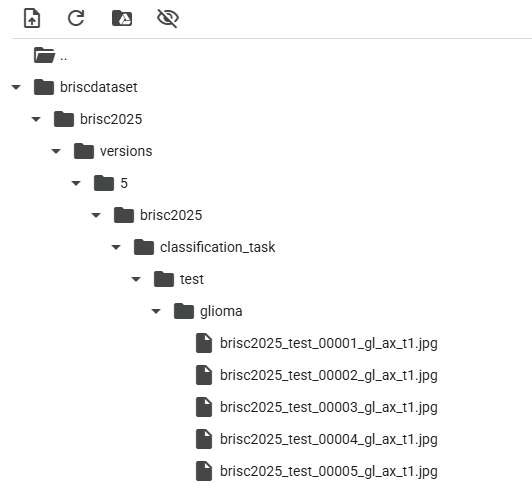

## 📂 2. Estructura del directorio

Navegamos recursivamente en el `BASE_DIR` (profundidad=2)

In [6]:
# In[2] — Directory Tree
def walk_dir(base, max_depth=2):
    for root, dirs, _ in os.walk(base):
        depth = root.replace(base, "").count(os.sep)
        if depth <= max_depth:
            indent = "  " * depth
            print(f"{indent}{os.path.basename(root)}/")
            for d in dirs:
                print(f"{indent}  {d}/")

print("## BRISC2025 Folder Layout:")
walk_dir(BASE_DIR, max_depth=2)


## BRISC2025 Folder Layout:
/
  classification_task/
  segmentation_task/
classification_task/
  test/
  train/
  test/
    glioma/
    meningioma/
    no_tumor/
    pituitary/
    glioma/
    meningioma/
    no_tumor/
    pituitary/
  train/
    glioma/
    meningioma/
    no_tumor/
    pituitary/
    glioma/
    meningioma/
    no_tumor/
    pituitary/
segmentation_task/
  test/
  train/
  test/
    images/
    masks/
    images/
    masks/
  train/
    images/
    masks/
    images/
    masks/


## 📊 3. Distribución de archivos

Contando cada imagen `.jpg` en cada uno de los split/clases.


In [7]:
# File Count Logic (no need to change if BASE_DIR is fixed)
def count_patterns(patterns):
    return sum(len(glob.glob(p)) for p in patterns)

# Classification
splits = ["train", "test"]
classes = ["glioma", "meningioma", "pituitary", "no_tumor"]
cls_records = []
for sp in splits:
    total = 0
    for cls in classes:
        pat = os.path.join(BASE_DIR, "classification_task", sp, cls, "*.jpg")
        cnt = count_patterns([pat])
        cls_records.append({'Split': sp, 'Class': cls, 'Count': cnt})
        total += cnt
    cls_records.append({'Split': sp, 'Class': 'Total', 'Count': total})
df_cls = pd.DataFrame(cls_records)

# Segmentation
types_ = ["images", "masks"]
seg_records = []
for sp in splits:
    for tp in types_:
        pats = [
            os.path.join(BASE_DIR, "segmentation_task", sp, tp, "*.jpg"),
            os.path.join(BASE_DIR, "segmentation_task", sp, tp, "*.png")
        ]
        cnt = count_patterns(pats)
        seg_records.append({'Split': sp, 'Type': tp, 'Count': cnt})
df_seg = pd.DataFrame(seg_records)

# Display
print("### Classification Counts")
display(df_cls)
print("### Segmentation Counts")
display(df_seg)


### Classification Counts


,Split,Class,Count
0,train,glioma,1147
1,train,meningioma,1329
2,train,pituitary,1457
3,train,no_tumor,1067
4,train,Total,5000
5,test,glioma,254
6,test,meningioma,306
7,test,pituitary,300
8,test,no_tumor,140
9,test,Total,1000


### Segmentation Counts


,Split,Type,Count
0,train,images,3933
1,train,masks,3933
2,test,images,860
3,test,masks,860


## 📊 4. Gráficos por distribuciones

Visualización del conjunto de datos


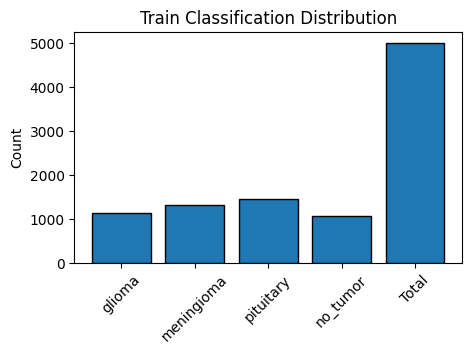

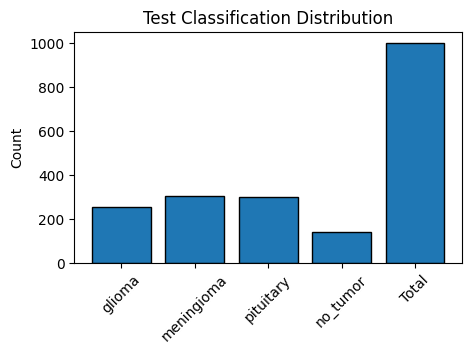

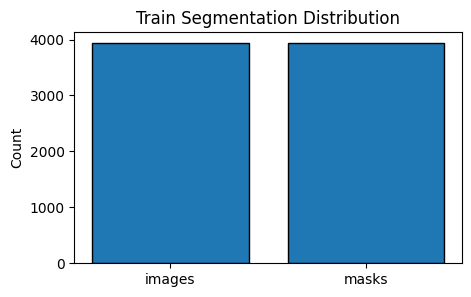

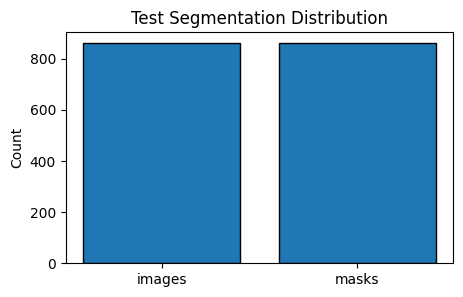

In [8]:
# In[4] — Distribution Plots
for sp in splits:
    sub = df_cls[df_cls.Split==sp]
    plt.figure(figsize=(5,3))
    plt.bar(sub.Class, sub.Count, edgecolor='k')
    plt.title(f"{sp.title()} Classification Distribution")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

for sp in splits:
    sub = df_seg[df_seg.Split==sp]
    plt.figure(figsize=(5,3))
    plt.bar(sub.Type, sub.Count, edgecolor='k')
    plt.title(f"{sp.title()} Segmentation Distribution")
    plt.ylabel("Count")
    plt.show()


## 📈 5. Clasificación por planos

Resumen anátomico dependiendo de los planos:

1. Ax: Axial
1. co: Coronal
1. sa: Sagittal

In [9]:
# In[5] — Per‑Plane Counts
planes = ["ax", "co", "sa"]
plane_records = []

for sp in splits:
    for cls in classes:
        for pl in planes:
            pat = os.path.join(
                BASE_DIR, "classification_task", sp, cls, f"*_{pl}_t1.jpg"
            )
            cnt = count_patterns([pat])
            plane_records.append({'Split': sp, 'Class': cls, 'Plane': pl, 'Count': cnt})

df_plane = pd.DataFrame(plane_records)
print("### Per‑Plane Counts Pivot")
display(df_plane.pivot_table(index='Plane', columns=['Split','Class'], values='Count'))


### Per‑Plane Counts Pivot


Split   test                                train                      \
Class glioma meningioma no_tumor pituitary glioma meningioma no_tumor   
Plane                                                                   
ax      85.0      137.0     52.0     124.0  394.0      423.0    352.0   
co      81.0       86.0     48.0      90.0  430.0      426.0    310.0   
sa      88.0       83.0     40.0      86.0  323.0      480.0    405.0   

Split            
Class pituitary  
Plane            
ax        426.0  
co        510.0  
sa        521.0

## 🖼️ 6. Imagen de ejemplo y máscaras

Ejemplo de una imagen de clasificación con su imagen de segmentación.

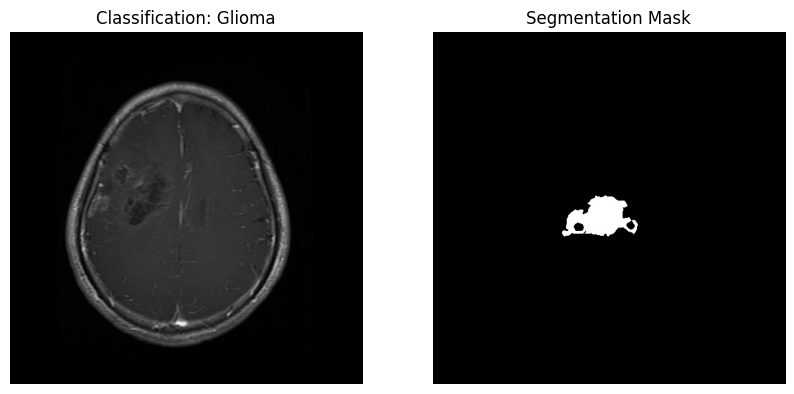

In [10]:
# In[6] — Sample Visualization
def first_file(folder, exts):
    for ext in exts:
        fl = glob.glob(os.path.join(folder, f"*.{ext}"))
        if fl: return fl[0]
    return None

img_path  = first_file(os.path.join(BASE_DIR, "classification_task/train/glioma"), ["jpg"])
mask_path = first_file(os.path.join(BASE_DIR, "segmentation_task/train/masks"), ["png","jpg"])

img  = Image.open(img_path)
mask = Image.open(mask_path)

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(img,  cmap="gray"); axes[0].set_title("Classification: Glioma"); axes[0].axis("off")
axes[1].imshow(mask, cmap="gray"); axes[1].set_title("Segmentation Mask");    axes[1].axis("off")
plt.show()

## 📈 7. Histogramas de frecuencias por píxeles

Píxeles de las imágenes y las máscaras.

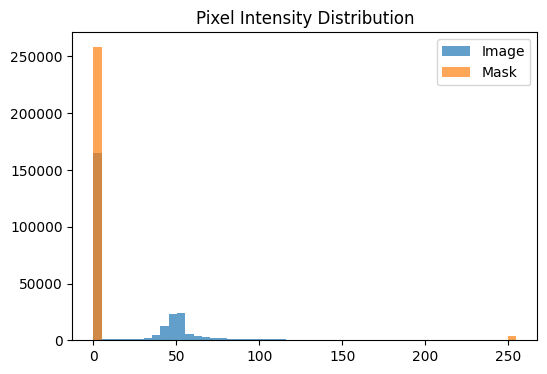

In [11]:
# In[7] — Histograms
arr_img  = np.array(img).ravel()
arr_mask = np.array(mask).ravel()

plt.figure(figsize=(6,4))
plt.hist(arr_img,  bins=50, alpha=0.7, label="Image")
plt.hist(arr_mask, bins=50, alpha=0.7, label="Mask")
plt.legend(); plt.title("Pixel Intensity Distribution"); plt.show()

## 📝 8. Parsing de metadata

Componentes del dataset transformados en una tabla. La columna Split dice a cuál corte irá cada imagen

In [12]:
# In[8] — Metadata Table
meta = []
for sp in splits:
    for cls in classes:
        # rafael: dependo de este objeto luego, asi que ahora el dataframe tiene TODAS las imagenes
        # antes solo tenia un subset
        files = glob.glob(os.path.join(BASE_DIR, "classification_task", sp, cls, "*.jpg"))
        for f in files:
            parts = os.path.basename(f).split("_")
            meta.append({
                "Filename": os.path.basename(f),
                "Split": parts[1],
                "Index": parts[2],
                "Tumor": parts[3],
                "Plane": parts[4],
                "Sequence": parts[5].split(".")[0]
            })
df_meta = pd.DataFrame(meta)
print("### Sample Filename Metadata")
display(df_meta)

### Sample Filename Metadata


,Filename,Split,Index,Tumor,Plane,Sequence
0,brisc2025_train_00060_gl_ax_t1.jpg,train,00060,gl,ax,t1
1,brisc2025_train_00037_gl_ax_t1.jpg,train,00037,gl,ax,t1
2,brisc2025_train_00252_gl_ax_t1.jpg,train,00252,gl,ax,t1
3,brisc2025_train_00494_gl_co_t1.jpg,train,00494,gl,co,t1
4,brisc2025_train_01002_gl_sa_t1.jpg,train,01002,gl,sa,t1
...,...,...,...,...,...,...
5995,brisc2025_test_00599_no_ax_t1.jpg,test,00599,no,ax,t1
5996,brisc2025_test_00659_no_co_t1.jpg,test,00659,no,co,t1
5997,brisc2025_test_00700_no_sa_t1.jpg,test,00700,no,sa,t1
5998,brisc2025_test_00643_no_co_t1.jpg,test,00643,no,co,t1


## 🔍 9. ejemplo de Overlay de la máscara

Overlay de la máscara en rojo sobre la resonancia.

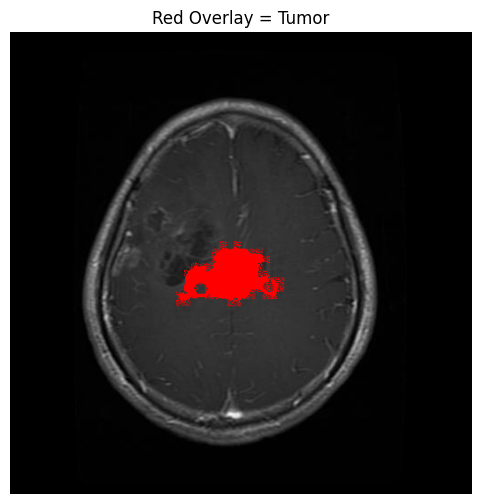

In [13]:
# In[9] — Overlay
img_rgb  = np.array(img.convert("RGB"))
mask_arr = np.array(mask)

overlay = img_rgb.copy()
overlay[mask_arr>0] = [255,0,0]

plt.figure(figsize=(6,6))
plt.imshow(overlay); plt.title("Red Overlay = Tumor"); plt.axis("off")
plt.show()

## 🔲 10. Grid aleatorio de ejemplos de clasificación

Desplegar un grid 3x3

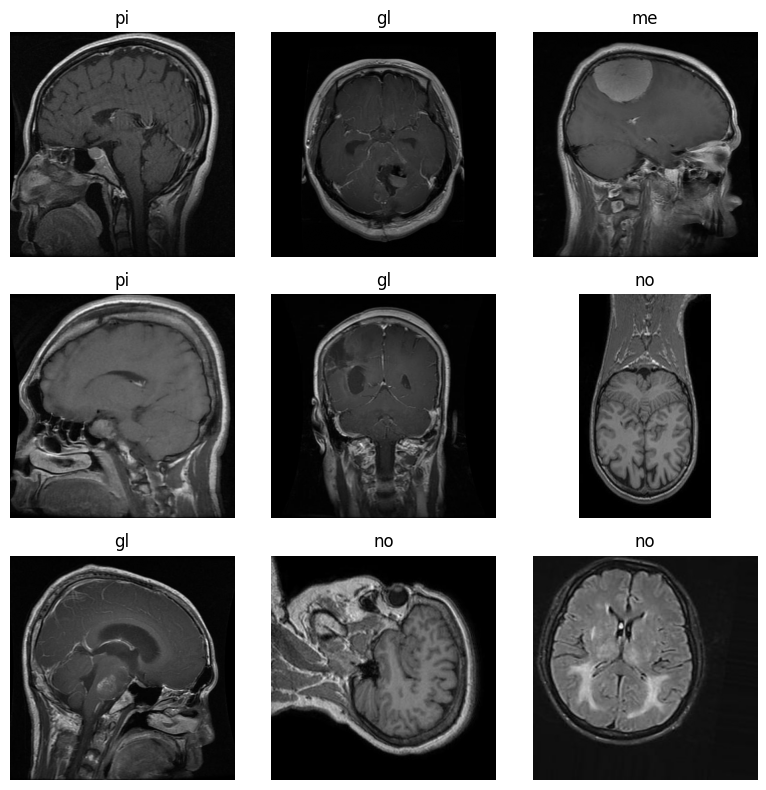

In [14]:
# In[10] — Random Grid
samples = glob.glob(os.path.join(BASE_DIR, "classification_task/train/*/*.jpg"))
grid = np.random.choice(samples, 9, replace=False)

fig, axes = plt.subplots(3,3, figsize=(8,8))
axes = axes.flatten()
for ax, fp in zip(axes, grid):
    im = Image.open(fp)
    cls = os.path.basename(fp).split("_")[3]
    ax.imshow(im, cmap="gray")
    ax.set_title(cls)
    ax.axis("off")
plt.tight_layout()
plt.show()

## 🔲 11. Dataloader para clasificacion


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

IMAGE_SIZE = 250

def get_transforms(mean, std):
    return transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

# usar este objeto con cautela. Carga TODAS las imagenes en memoria
# para hacer mas rapido el entrenamiento. No deben crearse muchas instancias o
# la session crasheara.
class BrainTumorDataset(Dataset):
    def __init__(self, df, root_dir):
        self.label_map = {'gl': 0, 'me': 1, 'no': 2, 'pi': 3}
        self.images = []
        self.labels = []
        self.meta = []

        grayscale = transforms.Grayscale(num_output_channels=1)

        for _, row in df.iterrows():
            tumor_to_file = {
                "gl":"glioma",
                "me":"meningioma",
                "no":"no_tumor",
                "pi":"pituitary"
            }
            tumor = row['Tumor']
            filename = row['Filename']

            img_path = os.path.join(root_dir, row['Split'], tumor_to_file[tumor], filename)

            image = Image.open(img_path).convert('RGB')
            self.images.append(grayscale(image))
            self.labels.append(self.label_map[tumor])
            self.meta.append({"path":img_path})

        # cargamos las imagenes y calculamos el mean y std para normalizar
        mean, std = self._calculate_mean_std()
        self.transform = get_transforms(mean, std)

    def _calculate_mean_std(self):
        as_tensor = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor()
        ])

        mean = torch.zeros(1)
        std = torch.zeros(1)

        for image in self.images:
            tensor_img = as_tensor(image)
            mean += tensor_img.mean([1, 2])
            std += tensor_img.std([1, 2])

        mean /= len(self.images)
        std /= len(self.images)

        return mean.tolist(), std.tolist()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        return self.transform(image), self.labels[idx]

    def get_with_meta(self,idx):
        image = self.images[idx]
        return image, self.labels[idx], self.meta[idx]

def create_dataloaders(batch_size=32):
    train_df = df_meta[df_meta['Split'] == 'train']
    test_df = df_meta[df_meta['Split'] == 'test']

    train_dataset = BrainTumorDataset(train_df, BASE_DIR + 'classification_task')
    test_dataset = BrainTumorDataset(test_df, BASE_DIR + 'classification_task')

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [16]:
# tarda algo por la carga de las imagenes en memoria. Igual mejor hacerlo ahora que en entrenamiento
train_loader, test_loader = create_dataloaders()

In [17]:
# solo correr si se quiere crear nuevas variables ya teniendo otras. por cuestiones de memoria
#del train_loader, test_loader

# ViT: El Visual Transformer

A continuación, tendrán la estructura del Visual Transformer. Su labor será utilizarlo en el task de `clasificación` de tumores del dataset `BRICS` haciendo énfasis en:

1. Cómo reajustar un codebase dado para un dataset de ejemplo?
1. Entender el modelo ViT para explicarlo a sus compañeros.
1. Cómo utilizar la matriz de atención en el caso de ViT? En qué ayuda en nuestro ejercicio?
1. Comparar nuestro ViT "casero" con el ViT de Huggingface.
1. Comparar ViT con un modelo de StackedAutoEncoders.
1. Utilizar `wandb` o `tensorboard` para el logging de los modelos.
1. Proyecto: Crear, en base al dataset dado, uno o unos gráficos custom de `wandb` siguiendo los ejemplos de [Custom charts](https://docs.wandb.ai/guides/app/features/custom-charts/)

Tienen libertad en todo el proyecto. Generen un pdf de resumen como hemos hecho en el curso y una presentación de no más de 15 diapositivas resumiendo la tarea.

## Seccion de respuesta

### Nuestro ViT

In [18]:
import torch.nn as nn
from einops import rearrange

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h) # Qué es esto? Investigar!!!!

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'Importante: La dimensión de las imágenes debe ser divisible por el número de patches (Dimensión/Patches = número entero)'

        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(), # Gaussian error linear unit como función de activación
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p) # Qué es esto? Investigar!!!!
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x, mask)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

In [19]:
import torch.nn.functional as F

def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()
    for i, (data, target) in enumerate(data_loader):
        data = data.cuda()
        target = target.cuda()
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())

In [20]:
def evaluate(model, data_loader, loss_history):
    model.eval()

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    # Recuerden que no necesitamos los gradientes en test.
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            target = target.cuda()
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

In [21]:
import time

# You can change the architecture here
model = ViT(image_size=IMAGE_SIZE, patch_size=IMAGE_SIZE // 2, num_classes=4, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128)
model = model.cuda()
# We also print the network architecture
model

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss_history, test_loss_history = [], []

In [23]:
N_EPOCHS = 10

# Gradually reduce the learning rate while training
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
start_time = time.time()
for epoch in range(1, N_EPOCHS + 1):
    print('Época:', epoch,'LR:', scheduler.get_last_lr())
    train_epoch(model, optimizer, train_loader, train_loss_history)
    evaluate(model, test_loader, test_loss_history)
    scheduler.step()

print('Tiempo de ejecución:', '{:5.2f}'.format(time.time() - start_time), 'segundos')

Época: 1 LR: [0.000857375]
[    0/ 5000 (  0%)]  Loss: 0.4728
[ 3200/ 5000 ( 64%)]  Loss: 0.2640

Average test loss: 0.4913  Accuracy:  805/ 1000 (80.50%)

Época: 2 LR: [0.0008145062499999999]
[    0/ 5000 (  0%)]  Loss: 0.3223
[ 3200/ 5000 ( 64%)]  Loss: 0.2495

Average test loss: 0.5039  Accuracy:  804/ 1000 (80.40%)

Época: 3 LR: [0.0007737809374999998]
[    0/ 5000 (  0%)]  Loss: 0.2197
[ 3200/ 5000 ( 64%)]  Loss: 0.3389

Average test loss: 0.5401  Accuracy:  811/ 1000 (81.10%)

Época: 4 LR: [0.0007350918906249997]
[    0/ 5000 (  0%)]  Loss: 0.2779
[ 3200/ 5000 ( 64%)]  Loss: 0.2132

Average test loss: 0.4301  Accuracy:  854/ 1000 (85.40%)

Época: 5 LR: [0.0006983372960937497]
[    0/ 5000 (  0%)]  Loss: 0.2405
[ 3200/ 5000 ( 64%)]  Loss: 0.0946

Average test loss: 0.4154  Accuracy:  868/ 1000 (86.80%)

Época: 6 LR: [0.0006634204312890621]
[    0/ 5000 (  0%)]  Loss: 0.0776
[ 3200/ 5000 ( 64%)]  Loss: 0.0652

Average test loss: 0.5144  Accuracy:  839/ 1000 (83.90%)

Época: 7 LR: [

### Huggingface ViT

In [ ]:
import torch
from transformers import ViTImageProcessorFast, ViTForImageClassification, pipeline
from datasets import load_dataset

pipeline = pipeline(
    task="image-classification",
    model="google/vit-base-patch16-224",
    torch_dtype=torch.float16,
    device=0
)
pipeline("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg")

In [ ]:
processor = ViTImageProcessorFast.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224") # Por qué el nombre es patch16-224?

In [ ]:
def setup_modelo_con_processor(
    n_classes=10, # Default 10 porque es MNIST
    freeze_parameters=True,
    pretrained_model="google/vit-base-patch16-224",
    debug=True
):
    """
    En esta sección:
    1) Llamamos al modelo ViT pre-entrenado
    2) Modificamos la cabecera
    3) Dedicimos si modificar TODOS los pesos o solamente la capa lineal
    """
    if debug:
        print("*** Setup modelo con processor ***")
    # Cargamos el processor
    processor = ViTImageProcessorFast.from_pretrained(pretrained_model)

    # Modificamos la configuración del clasificador
    config = ViTConfig.from_pretrained(pretrained_model)
    config.num_labels = n_classes
    config.id2label = {i: str(i) for i in range(n_classes)}
    config.label2id = {str(i): i for i in range(n_classes)}

    model = ViTForImageClassification.from_pretrained(
        pretrained_model,
        config=config ,
        ignore_mismatched_sizes=True
    )

    if debug:
        print(f"Modelo cargado con {config.num_labels} clases")
        print(f"Dimensión de la capa de clasificación (luego del cambio) {model.classifier.weight.shape}")

    # To Freeze or not to Freeze
    if freeze_parameters:
        for param in model.vit.parameters():
            param.requires_grad = False

    return model, processor, config


In [ ]:
def compute_metrics(eval_pred):
    """Compute accuracy metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": accuracy_score(labels, predictions)}

def fine_tune_con_trainer(model, train_dataset, test_dataset, output_dir="./UCV-vit-mnist-finetuned", debug=True):
    """Fine-tune using HuggingFace Trainer"""

    # Training arguments
    # Verificar https://huggingface.co/docs/transformers/en/main_classes/trainer
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=f'{output_dir}/logs',
        logging_steps=100,
        eval_strategy="steps",
        eval_steps=500,
        save_strategy="steps",
        save_steps=500,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        remove_unused_columns=False,
        push_to_hub=False,
        report_to=None,  # Disable wandb/tensorboard !!!!!PROYECTO!!!!!
    )

    # Initialiar el entrenador
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )
    if debug:
        print("Comenzando fine-tuning...")

    # Entrenar el modelo
    trainer.train()

    # Evaluar el model
    if debug:
        print("Evaluating on test set...")
    eval_results = trainer.evaluate()

    if debug:
        print(f"Test Accuracy: {eval_results['eval_accuracy']:.4f}")

    # Salvar el modelo
    trainer.save_model()
    if debug:
        print(f"Model saved to {output_dir}")

    return trainer, eval_results

In [ ]:
def test_inference(model, processor, num_samples=5):
    """Test inference en un split aleatorio de los datos"""

    # Load test dataset
    mnist = load_dataset("mnist")

    device = next(model.parameters()).device
    model.eval()

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        # Get random sample
        idx = np.random.randint(0, len(mnist['test']))
        sample = mnist['test'][idx]
        image = sample['image']
        true_label = sample['label']

        # Preprocess
        rgb_image = image.convert('RGB')
        inputs = processor(images=rgb_image, return_tensors="pt")
        pixel_values = inputs['pixel_values'].to(device)

        # Predict
        with torch.no_grad():
            outputs = model(pixel_values=pixel_values)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_class = torch.argmax(probabilities, dim=-1).item()
            confidence = probabilities.max().item()

        # Plot
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'True: {true_label}\nPred: {predicted_class}\nConf: {confidence:.3f}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

## Self-Attention y Transformers

En esta sección, tenemos la implementación del mecanismo `self-attention` implementado por el grupo docente de la UCV en `Numpy` y `PyTorch`. Luego, tenemos una implementación base de un `ViT` de 6 capas usando el dataset `MNIST`.

Verificamos que tenemos acceso a la GPU. Si no están conectados, se verá como en la primera celda. Si están conectados, como en la segunda.

In [ ]:
!nvidia-smi

Sat Aug  2 15:30:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!nvidia-smi

Sat Aug  2 15:30:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### El mecanismo `Self-attention`

Para entender el mecanismo visto en clase, implementamos primero usando `numpy` y de manera "manual`. Hagan énfaseis en las dimensiones y en los cálculos en cada sección cuando multiplicamos las matrices.

Modifiquen las variables a conveniencia y vean cómo se modifican las salidas.

In [ ]:
import math
import numpy as np
from numpy.random import randn

# I. Definimos la entrada X
# X consiste de 32 datos, cada uno de ellos de dimensión 256
n = 32
d = 256
X = randn(n, d) # (32, 256)

# II. Generamos los pesos de proyección como vimos en clases. Wq, Wk, Wv: queries, keys, values.
Wq = randn(d, d) #(256, 256)
Wk = randn(d, d)
Wv = randn(d, d)

# III. Projectamos X para conseguir los vectores de queries, keys y value.
Q = np.dot(X, Wq) # (32, 256)
K = np.dot(X, Wk)
V = np.dot(X, Wv)

# IV. Calculamos la matriz de self-attention, almacenada como A.
# Luego, aplicamos la función softmax
# A = softmax(QK^T / \sqrt{d})

# Definimos la función SoftMax
def softmax(z):
    z = np.clip(z, 100, -100) # clip en el caso de tener valores muy grandes
    tmp = np.exp(z)
    res = np.exp(z) / np.sum(tmp, axis=1)
    return res

A = softmax(np.dot(Q, K.transpose())/math.sqrt(d)) #(32, 32)

# V. Vemos la salida del self-attention
# outputs = A * V
outputs = np.dot(A, V) #(32, 256)

print("La salida de atención\n {}".format(outputs))

La salida de atención
 [[-1.55636825  2.4257697  -1.16825908 ... -0.84499973  1.14296167
  -1.26810931]
 [-1.55636825  2.4257697  -1.16825908 ... -0.84499973  1.14296167
  -1.26810931]
 [-1.55636825  2.4257697  -1.16825908 ... -0.84499973  1.14296167
  -1.26810931]
 ...
 [-1.55636825  2.4257697  -1.16825908 ... -0.84499973  1.14296167
  -1.26810931]
 [-1.55636825  2.4257697  -1.16825908 ... -0.84499973  1.14296167
  -1.26810931]
 [-1.55636825  2.4257697  -1.16825908 ... -0.84499973  1.14296167
  -1.26810931]]


### Implementando la capa `Self-attention` con PyTorch

In [ ]:
import math
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, dim_input, dim_q, dim_v):
        '''
        dim_input: the dimension of each sample
        dim_q: dimension of Q matrix, should be equal to dim_k
        dim_v: dimension of V matrix, also the  dimension of the attention output
        '''
        super(SelfAttention, self).__init__()

        self.dim_input = dim_input
        self.dim_q = dim_q
        self.dim_k = dim_q
        self.dim_v = dim_v

        # Definimos la proyección lineal (Igual que en ML)
        self.linear_q = nn.Linear(self.dim_input, self.dim_q, bias=False)
        self.linear_k = nn.Linear(self.dim_input, self.dim_k, bias=False)
        self.linear_v = nn.Linear(self.dim_input, self.dim_v, bias=False)
        self._norm_fact = 1 / math.sqrt(self.dim_k)

    def forward(self, x):
        batch, n, dim_q = x.shape

        q = self.linear_q(x) # (batchsize, seq_len, dim_q)
        k = self.linear_k(x) # (batchsize, seq_len, dim_k)
        v = self.linear_v(x) # (batchsize, seq_len, dim_v)
        print(f'x.shape:{x.shape} \n Q.shape:{q.shape} \n K.shape:{k.shape} \n V.shape:{v.shape}')

        dist = torch.bmm(q, k.transpose(1,2)) * self._norm_fact
        dist = torch.softmax(dist, dim=-1)
        print('attention matrix: ', dist.shape)

        outputs = torch.bmm(dist, v)
        print('attention outputs: ', outputs.shape)

        return outputs


batch_size = 32 # número de filas del batch
dim_input = 128 # Dimensión de cada item dentro del batch (cuántas características tiene)
seq_len = 20 # Dimensión de la secuencia

x = torch.randn(batch_size, seq_len, dim_input)
self_attention = SelfAttention(dim_input, dim_q = 64, dim_v = 32)

attention = self_attention(x)

print(attention)

x.shape:torch.Size([32, 20, 128]) 
 Q.shape:torch.Size([32, 20, 64]) 
 K.shape:torch.Size([32, 20, 64]) 
 V.shape:torch.Size([32, 20, 32])
attention matrix:  torch.Size([32, 20, 20])
attention outputs:  torch.Size([32, 20, 32])
tensor([[[-4.0603e-02,  2.0455e-02, -1.8148e-01,  ...,  1.9333e-01,
          -1.4896e-01, -2.1916e-01],
         [-1.1553e-01,  5.6655e-02, -2.3672e-01,  ...,  2.0722e-01,
          -7.9237e-03, -1.1751e-01],
         [-7.0736e-02,  1.4461e-01, -1.9881e-01,  ...,  1.4693e-01,
          -2.0223e-03, -1.1806e-01],
         ...,
         [-4.9361e-02,  1.4229e-02, -2.0948e-01,  ...,  1.8950e-01,
          -2.9063e-02, -1.0505e-02],
         [-1.1649e-01,  6.1520e-02, -2.2823e-01,  ...,  1.9281e-01,
           2.6846e-02, -1.5851e-01],
         [-9.2624e-02,  4.5874e-02, -2.7790e-01,  ...,  8.1177e-02,
          -1.0301e-02, -2.2062e-01]],

        [[ 2.3413e-02, -5.2433e-02, -6.2614e-03,  ...,  1.7204e-03,
           1.7961e-01, -1.0045e-01],
         [ 6.9084e-02

### Transformers

En esta sección, implementamos el modelo de 6 capas `ViT` (Vision Transformer) y lo entrenamos en el dataset `MNIST` como ejemplo. Consideramos, en consecuencia, el task de clasificación.

#### El Dataloader

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, utils
from torchvision.datasets import MNIST

def get_mnist_loader(batch_size=100, shuffle=True):
    """

    :return: train_loader, test_loader
    """
    train_dataset = MNIST(root='../data',
                          train=True,
                          transform=torchvision.transforms.ToTensor(),
                          download=True)
    test_dataset = MNIST(root='../data',
                         train=False,
                         transform=torchvision.transforms.ToTensor(),
                         download=True)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               shuffle=shuffle)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False)
    return train_loader, test_loader

### El modelo ViT

Recordemos que cada bloque de Transformer tiene 2 módulos:

1. El de Self-attention
1. El Lineal

In [ ]:
from einops import rearrange

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h) # Qué es esto? Investigar!!!!

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'Importante: La dimensión de las imágenes debe ser divisible por el número de patches (Dimensión/Patches = número entero)'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(), # Gaussian error linear unit como función de activación
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p) # Qué es esto? Investigar!!!!
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x, mask)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

### Entrenamiento y test

In [ ]:
import torch.nn.functional as F

def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        data = data.cuda()
        target = target.cuda()
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())

In [ ]:
def evaluate(model, data_loader, loss_history):
    model.eval()

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    # Recuerden que no necesitamos los gradientes en test.
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            target = target.cuda()
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

## Entrenando!!

In [ ]:
import time

# You can change the architecture here
model = ViT(image_size=28, patch_size=7, num_classes=10, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128)
model = model.cuda()
# We also print the network architecture
model

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss_history, test_loss_history = [], []

In [ ]:
N_EPOCHS = 20

train_loader, test_loader = get_mnist_loader(batch_size=128, shuffle=True)

# Gradually reduce the learning rate while training
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

start_time = time.time()
for epoch in range(1, N_EPOCHS + 1):
    print('Época:', epoch,'LR:', scheduler.get_last_lr())
    train_epoch(model, optimizer, train_loader, train_loss_history)
    evaluate(model, test_loader, test_loss_history)
    scheduler.step()

print('Tiempo de ejecución:', '{:5.2f}'.format(time.time() - start_time), 'segundos')

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.91MB/s]


Época: 1 LR: [0.001]
[    0/60000 (  0%)]  Loss: 2.3547
[12800/60000 ( 21%)]  Loss: 1.1013
[25600/60000 ( 43%)]  Loss: 0.4720
[38400/60000 ( 64%)]  Loss: 0.1886
[51200/60000 ( 85%)]  Loss: 0.1903

Average test loss: 0.2041  Accuracy: 9362/10000 (93.62%)

Época: 2 LR: [0.00095]
[    0/60000 (  0%)]  Loss: 0.2119
[12800/60000 ( 21%)]  Loss: 0.3354
[25600/60000 ( 43%)]  Loss: 0.2206
[38400/60000 ( 64%)]  Loss: 0.0979
[51200/60000 ( 85%)]  Loss: 0.1862

Average test loss: 0.1510  Accuracy: 9533/10000 (95.33%)

Época: 3 LR: [0.0009025]
[    0/60000 (  0%)]  Loss: 0.2024
[12800/60000 ( 21%)]  Loss: 0.0601
[25600/60000 ( 43%)]  Loss: 0.0579
[38400/60000 ( 64%)]  Loss: 0.1377
[51200/60000 ( 85%)]  Loss: 0.0609

Average test loss: 0.1094  Accuracy: 9654/10000 (96.54%)

Época: 4 LR: [0.000857375]
[    0/60000 (  0%)]  Loss: 0.1138
[12800/60000 ( 21%)]  Loss: 0.0896
[25600/60000 ( 43%)]  Loss: 0.1243
[38400/60000 ( 64%)]  Loss: 0.0463
[51200/60000 ( 85%)]  Loss: 0.0784

Average test loss: 0.0854 

# Hugginface vs UCV

Ahora, comparemos el rendimiento de nuestro `ViT` con el de Hugginface usando el tutorial de Hugginface [Vision Transformer (ViT)](https://huggingface.co/docs/transformers/en/model_doc/vit)

El tutorial básico para usar un pipeline es el siguiente:

In [ ]:
import torch
from transformers import ViTImageProcessorFast, ViTForImageClassification, pipeline
from datasets import load_dataset

pipeline = pipeline(
    task="image-classification",
    model="google/vit-base-patch16-224",
    torch_dtype=torch.float16,
    device=0
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Device set to use cuda:0


In [ ]:
pipeline("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg")

[{'label': 'lynx, catamount', 'score': 0.43471530079841614},
 {'label': 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
  'score': 0.03472110256552696},
 {'label': 'snow leopard, ounce, Panthera uncia',
  'score': 0.03236362338066101},
 {'label': 'Egyptian cat', 'score': 0.023956838995218277},
 {'label': 'tiger cat', 'score': 0.02285977452993393}]

El problema fundamental para nosotros, es que el modelo `google/vit-base-patch16-224` acepta imágenes $224 \times 224$.

Por lo tanto, tenemos que usar el `ViTImageProcessorFast` para poder escalarlas.

Hacemos el proceso para MNIST

In [ ]:
processor = ViTImageProcessorFast.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224") # Por qué el nombre es patch16-224?

In [ ]:
mnist = load_dataset("mnist")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
primera_imagen = mnist["train"][0]["image"]

In [ ]:
primera_imagen

In [ ]:
print(primera_imagen.size)

(28, 28)


In [ ]:
print(primera_imagen.mode)

L


In [ ]:
if primera_imagen.mode != "RGB":
    primera_imagen = primera_imagen.convert('RGB')

In [ ]:
primera_imagen

In [ ]:
primera_imagen.mode

'RGB'

In [ ]:
inputs = processor(primera_imagen, return_tensors="pt")

In [ ]:
inputs

{'pixel_values': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]])}

In [ ]:
print("Shape de la imagen", inputs["pixel_values"].shape)

Shape de la imagen torch.Size([1, 3, 224, 224])


Fíjense cómo ahora la imagen es `(1, 3, 224, 224)` referente a:

1. Batch size: 1
1. Canales: 3
1. Ancho: 224
1. Alto: 224

In [ ]:
from torch.nn.functional import softmax

with torch.no_grad():
    outputs = model(**inputs)
    predicciones = softmax(outputs.logits, dim=-1)
    clase_id = predicciones.argmax().item()
    confianza = predicciones.max().item()

print(f"La clase es {clase_id}")
print(f"La confianza es {confianza}")


La clase es 512
La confianza es 0.06623367965221405


Como el `ViT` de huggingface fue entrenado para 1000 clases. Debemos reutilizarlo y modificarlo para las clases de MNIST.

Recordemos que el proceso de reutilizar un modelo para modificar solamente las capas de clasificación se conoce como `fine-tuning`

# Fine Tuning con MNIST

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import (
    ViTImageProcessorFast,
    ViTForImageClassification,
    ViTConfig,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import load_dataset
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import os
from tqdm import tqdm

## Creando el Dataset

In [ ]:
class MNISTDataset(Dataset):
    """Custom Dataset para MNIST con ViT preprocessing"""

    def __init__(self, dataset, processor, transform=None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']

        # Convert grayscale to RGB
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Apply custom transforms if any
        if self.transform:
            image = self.transform(image)

        # Process with ViT processor
        inputs = self.processor(images=image, return_tensors="pt")

        return {
            'pixel_values': inputs['pixel_values'].squeeze(0),  # (1, *) -> (*) Remueve la dimensión del batch
            'labels': torch.tensor(label, dtype=torch.long)
        }

## Setup y procesador

En esta sección, cargamos el modelo pre entrenado de Huggingface y lo modificamos al task de clasificación de MNIST.

Fíjense que la cantidad de clases a usar depende de nosotros (cambiando el parámetro)

In [ ]:
def setup_modelo_con_processor(
    n_classes=10, # Default 10 porque es MNIST
    freeze_parameters=True,
    pretrained_model="google/vit-base-patch16-224",
    debug=True
):
    """
    En esta sección:
    1) Llamamos al modelo ViT pre-entrenado
    2) Modificamos la cabecera
    3) Dedicimos si modificar TODOS los pesos o solamente la capa lineal
    """
    if debug:
        print("*** Setup modelo con processor ***")
    # Cargamos el processor
    processor = ViTImageProcessorFast.from_pretrained(pretrained_model)

    # Modificamos la configuración del clasificador
    config = ViTConfig.from_pretrained(pretrained_model)
    config.num_labels = n_classes
    config.id2label = {i: str(i) for i in range(n_classes)}
    config.label2id = {str(i): i for i in range(n_classes)}

    model = ViTForImageClassification.from_pretrained(
        pretrained_model,
        config=config ,
        ignore_mismatched_sizes=True
    )

    if debug:
        print(f"Modelo cargado con {config.num_labels} clases")
        print(f"Dimensión de la capa de clasificación (luego del cambio) {model.classifier.weight.shape}")

    # To Freeze or not to Freeze
    if freeze_parameters:
        for param in model.vit.parameters():
            param.requires_grad = False

    return model, processor, config


## Carga y preparación de los datos

Esta sección usa el MNIST dataset creado antes para devolver el train_dataset y el test_dataset

In [ ]:
def cargar_y_preparar_datos(processor, debug=True):
    """Cargar datos usando el processor"""
    if debug:
        print("*** Cargar y preparar datos ***")
    # Ejemplo con MNIST
    # Acá se puede modificar para tumores
    mnist = load_dataset("mnist")

    # Crear datasets
    train_dataset = MNISTDataset(mnist['train'], processor)
    test_dataset = MNISTDataset(mnist['test'], processor)
    if debug:
        print(f"Datos de entrenamiento: {len(train_dataset)}")
        print(f"Datos de test: {len(test_dataset)}")

    return train_dataset, test_dataset

## Trainer

In [ ]:
def compute_metrics(eval_pred):
    """Compute accuracy metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": accuracy_score(labels, predictions)}

def fine_tune_con_trainer(model, train_dataset, test_dataset, output_dir="./UCV-vit-mnist-finetuned", debug=True):
    """Fine-tune using HuggingFace Trainer"""

    # Training arguments
    # Verificar https://huggingface.co/docs/transformers/en/main_classes/trainer
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=f'{output_dir}/logs',
        logging_steps=100,
        eval_strategy="steps",
        eval_steps=500,
        save_strategy="steps",
        save_steps=500,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        remove_unused_columns=False,
        push_to_hub=False,
        report_to=None,  # Disable wandb/tensorboard !!!!!PROYECTO!!!!!
    )

    # Initialiar el entrenador
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )
    if debug:
        print("Comenzando fine-tuning...")

    # Entrenar el modelo
    trainer.train()

    # Evaluar el model
    if debug:
        print("Evaluating on test set...")
    eval_results = trainer.evaluate()

    if debug:
        print(f"Test Accuracy: {eval_results['eval_accuracy']:.4f}")

    # Salvar el modelo
    trainer.save_model()
    if debug:
        print(f"Model saved to {output_dir}")

    return trainer, eval_results

In [ ]:
def test_inference(model, processor, num_samples=5):
    """Test inference en un split aleatorio de los datos"""

    # Load test dataset
    mnist = load_dataset("mnist")

    device = next(model.parameters()).device
    model.eval()

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        # Get random sample
        idx = np.random.randint(0, len(mnist['test']))
        sample = mnist['test'][idx]
        image = sample['image']
        true_label = sample['label']

        # Preprocess
        rgb_image = image.convert('RGB')
        inputs = processor(images=rgb_image, return_tensors="pt")
        pixel_values = inputs['pixel_values'].to(device)

        # Predict
        with torch.no_grad():
            outputs = model(pixel_values=pixel_values)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_class = torch.argmax(probabilities, dim=-1).item()
            confidence = probabilities.max().item()

        # Plot
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'True: {true_label}\nPred: {predicted_class}\nConf: {confidence:.3f}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

### Salvando y carga en el caso de modelos salvados

In [ ]:
def save_model_for_deployment(model, processor, save_path="./vit-mnist-final", load=False, debug=True):
    """
    Salvar y upload de modelos
    """
    if load:
            # Test loading
        try:
            loaded_model = ViTForImageClassification.from_pretrained(save_path)
            loaded_processor = ViTImageProcessorFast.from_pretrained(save_path)
            if debug:
                print("✓ Modelo y processor cargados correctamente!")
            return loaded_model, loaded_processor
        except Exception as e:
            print(f"✗ Error loading model: {e}")
            return None, None
    else:
        os.makedirs(save_path, exist_ok=True)

        # Save model
        model.save_pretrained(save_path)

        # Save processor
        processor.save_pretrained(save_path)

        if debug:
            print(f"Modelo y processor salvados en {save_path}")



## Fine-Tuning pipeline

1. Setup y processor
1. Cargar datos
1. Entrenar

In [ ]:
print("ViT fine tuning")

model, processor, config = setup_modelo_con_processor()
train_dataset, test_dataset = cargar_y_preparar_datos(processor)
trainer, eval_results = fine_tune_con_trainer(model, train_dataset, test_dataset)

ViT fine tuning
*** Setup modelo con processor ***


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo cargado con 10 clases
Dimensión de la capa de clasificación (luego del cambio) torch.Size([10, 768])
*** Cargar y preparar datos ***
Datos de entrenamiento: 60000
Datos de test: 10000


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Comenzando fine-tuning...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rcontreraspimentel (rcontreraspimentel-ucv) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy
500,1.685100,1.567335,0.704400
1000,0.975000,0.912307,0.835900
1500,0.711800,0.675882,0.873100
2000,0.591200,0.560458,0.885100
2500,0.505000,0.488101,0.897300
3000,0.474500,0.440747,0.904900
3500,0.408500,0.405908,0.911200


KeyboardInterrupt: 

## Ejemplo de predicciones

In [ ]:
test_inference(model, processor, num_samples=5)

# Salvando modelo en directorio custom

Colocamos la bandera `load=False` si solo queremos salvar

In [ ]:
save_model_for_deployment(model, processor, save_path="./vit-mnist-final", load=False)

# Cargando un modelo salvado

In [ ]:
model_saved, processor_saved = save_model_for_deployment(model=None, processor=None, save_path="./vit-mnist-final", load=True)

In [ ]:
test_inference(model_saved, processor_saved, num_samples=5)